<a href="https://colab.research.google.com/github/florencevivier/FaceDetection-HOG-SVM/blob/main/face_detection_hog_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is about creating a face detection program, using few calculation capacity, no pre-trained model, without a starting dataset. </br>
The parallel aim is to conduct a literature search and apply the startegies to our case. </br>
The historic paper about a similar study is dated 2005 and written by Navneet Dalal and Bill Triggs which title is 'Histograms of oriented gradients for human detection'. It describes an interesting approach consisting in calculating the histograms of oriented gradients for each image of the train and test datasets, and use them as inputs to train a linear SVM to classify images between containing human faces and not. </br>
Then, to apply it on a given picture and individualize in it human face(s), some others techniques need to be used, as explained by Adrian Rosebrock in his articles:
- Sliding window technique: https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
- Image pyramid: https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/ </br>

These publications served as starting point to write the program.



## Import Libraries

In [ ]:
# Datasets
from sklearn.datasets import fetch_olivetti_faces
import tensorflow_datasets as tfds

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.image as mpimg
import urllib.request
import cv2
import requests
import imutils
import matplotlib.patches as patches

# Step 1: Positive samples
First of all, a dataset of positive samples is needed, that's saying pictures representing human faces. </br>
In order to start in the best possible conditions, we choose images of only faces: the olivetti-faces dataset, from scikitlearn library.


In [ ]:
olivetti_faces = fetch_olivetti_faces()
# To treat it more easily, this object type is changed to np array
X_pos = olivetti_faces.data

In [ ]:
print(X_pos.shape)

(400, 4096)


The dataset contains 400 images. Each row corresponds to a ravelled face image of original size 64 x 64 pixels.

In [ ]:
# Extraction of images dimensions as variables x and y
_, x, y = olivetti_faces.images.shape
print(f"Dimensions of images: {x,y}")

Dimensions of images: (64, 64)


In [ ]:
# Pixels values
print(f'Minimum value = {X_pos.min()} , Maximum value = {X_pos.max()}')

Minimum value = 0.0 , Maximum value = 1.0


The data are already normalized.

In order to better understand the dataset, a visualization of 12 random images is performed.

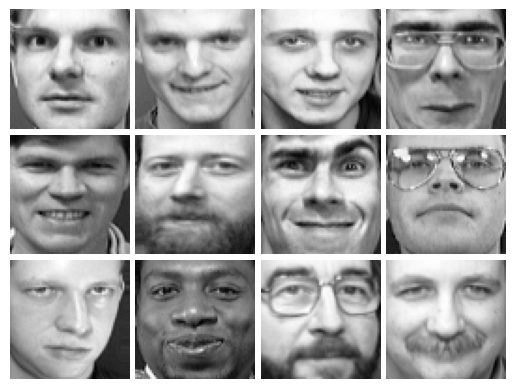

In [ ]:
# X array get reshaped to have the 64*64 format ready for image visualization
X_pos = X_pos.reshape(X_pos.shape[0], x, y)

# Random selection of 12 images
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
indexes = np.random.randint(0, len(X_pos), size=12)

# Plot of the images
fig = plt.figure()
for i in range(len(indexes)):
  plot = fig.add_subplot(3, 4, i+1)
  plt.imshow(X_pos[indexes[i]], cmap = "gray")
  plt.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

The images well correspond to human faces in gray scale, in size 64*64 pixels.

In [ ]:
X_pos.shape

(400, 64, 64)

# Step 2: Negative samples
Now, a dataset of negative samples is needed, that's saying pictures representing every kind of object except human faces. </br>
We choose Caltech101 dataset, containing thousands of images divided in 101 differents classes. </br>
A first step is to individualize the classes with possible human faces, and remove them.</br>
Then, as in this project we have 400 positive examples, we decide to work with a similar number of negative examples, and have a balanced dataset.

In [ ]:
# Data download
tf_data, tf_info = tfds.load('caltech101', as_supervised=True, with_info=True)

In [ ]:
# Numbers of downloaded images
# We note that there is only a train set in this dataset
num_pics = tf_info.splits['train'].num_examples
print("Total number of images:", num_pics)

Total number of images: 3060


In [ ]:
# List of the classes
class_names = tf_info.features['label'].names
print(class_names)

['accordion', 'airplanes', 'anchor', 'ant', 'background_google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'faces', 'faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

In this list 3 classes could contain human faces: 'faces', 'faces_easy' and 'buddha'. We remove them.

In [ ]:
# Access to the images
dataset = tf_data['train']

# Classes to exclude and indexes of images corresponding to these classes
excluded_classes = ['faces', 'faces_easy', 'buddha']
excluded_indices = [class_names.index(excl_class) for excl_class in excluded_classes]

# dataset filtering
filtered_dataset = dataset.filter(lambda image, label: ~tf.reduce_any(tf.equal(label, excluded_indices)))

In [ ]:
# Number of remaining images
count = sum(1 for _ in filtered_dataset)
print(f"Number of examples in filtered dataset: {count}")

Number of examples in filtered dataset: 2970


The images should have similar format than the positive examples ones:
* gray scale
* normalized pixel values
* 64*64 size

It seems better to don't change the images proportions when resizing from original dimensions to (64,64). </br>
In a first time,  ImageOps.pad() function has been used to resize and if necessary to add paddings (black edges). But it could lead the ML model to recognize black edges as sign of belonging to the negative class. So a crop in the middle seems a better idea.


In [ ]:
def preprocess_image(image_array, target_size=(64, 64)):
    # Convert in PIL object
    pil_img = Image.fromarray(image_array)

    # Convert in gray scale
    pil_img = pil_img.convert('L')

    # Width and height of the image, and individualization of the littlest
    width, height = pil_img.size
    min_dim = min(width, height)

    # Coordinates to proceed to the central crop
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop of the central square
    pil_img = pil_img.crop((left, top, right, bottom))

    # Resizing to (64*64)
    pil_img = pil_img.resize(target_size, Image.BICUBIC)

    # Save as np array and normalization of pixel values
    gray_array = np.array(pil_img).astype(np.float32) / 255

    return gray_array

In [ ]:
# Application of the function to all images in filtered_dataset
processed_images = []

for image, label in tfds.as_numpy(filtered_dataset):
    processed = preprocess_image(image)
    processed_images.append(processed)

X_neg = np.array(processed_images)

In [ ]:
# Dimensions of the negative examples dataset
print(f"Dimension of X_neg: {X_neg.shape}")

Dimension of X_neg: (2970, 64, 64)


From the remained 2970 images, we want to keep a similar number of negative examples than positive ones (equale to 400) for the future model, so we select only 15% of the examples.

In [ ]:
# Number of examples to keep
num_samples = int(0.15 * X_neg.shape[0])

# Creation of random indices to select the examples
random_indices = np.random.choice(X_neg.shape[0], size=num_samples, replace=False)

# Creation of the new dataset
X_neg = X_neg[random_indices]

In [ ]:
# Dimensions of the negative examples dataset
print(f"Dimension of X_neg: {X_neg.shape}")

Dimension of X_neg: (445, 64, 64)


At this point a visualization of 12 random images is performed.

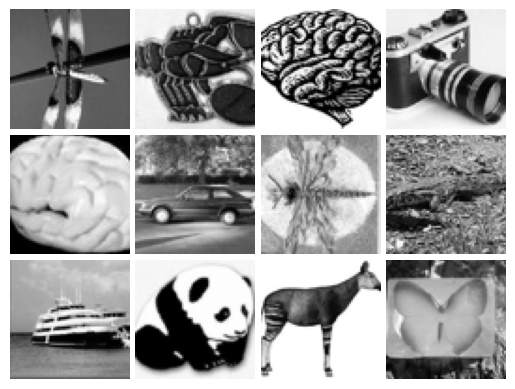

In [ ]:
# Random selection of 12 images
indexes = np.random.randint(0, len(X_neg), size=12)

# Plot of the images
fig = plt.figure()
for i in range(len(indexes)):
  plot = fig.add_subplot(3, 4, i+1)
  plt.imshow(X_neg[indexes[i]], cmap = "gray")
  plt.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We can see that images have been transformed as required, and represent every kind of subjects but human faces.

# Step 3: Construction of an unique dataset

For examples from both datasets, a label is added: 0 for examples from the negative class (pictures without human faces) and 1 for examples from positive class (human faces). </br>
To do it, a function is created.

In [ ]:
def adding_labels(X, label):
  # Flatten images
  flattened = X.reshape(len(X), -1)

  # Creation of arrays corresponding to labels
  if label == 1:
    labels = np.ones((len(X), 1))

  if label == 0:
     labels = np.zeros((len(X), 1))

  # Concatenation
  X_final = np.hstack((flattened, labels))

  return X_final

In [ ]:
# Application of the function on X_neg and X_pos
X_pos_final = adding_labels(X_pos, 1)
X_neg_final = adding_labels(X_neg, 0)

The final dataset is created from the union of positive and negative ones.

In [ ]:
X_final = np.concatenate((X_pos_final, X_neg_final), axis=0)

# Random mixing of the examples
np.random.shuffle(X_final)

Before carrying on, it is usefull to separate X and y (labels) arrays.

In [ ]:
X = X_final[:, :-1]
y = X_final[:, -1]

At this point, we check the images with a visualization of 12 random pictures.

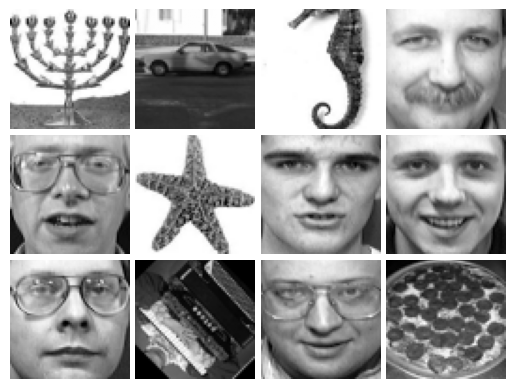

In [ ]:
# Random selection of 12 images
indexes = np.random.randint(0, len(X), size=12)

X_viz = X.reshape(len(X), 64, 64)

# Plot of the images
fig = plt.figure()
for i in range(len(indexes)):
  plot = fig.add_subplot(3, 4, i+1)
  plt.imshow(X_viz[indexes[i]], cmap = "gray")
  plt.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

As expected we see both positive and negative examples.

From now to the end of the project, it is better to manipulate pictures in 2D. So we keep X_viz as dataset.

In [ ]:
X_viz.shape

(845, 64, 64)

# Step 4: Classification model creation

A model is created to recognize no-face pictures vs pictures with human face. </br>
The project asks for a light, easy-to-use and no-pretrained model. </br>
The study lead by Navneet Dalal and Bill Triggs about HOG extraction and use is an interesting approach. It consists of calculating the histograms of oriented gradients for each image of the dataset, and use them as inputs to train a linear SVM to classify images between containing human faces and not. <br/>
In this part, the HOG features will be extracted and the model will be trained and evaluated.

## Train - test sets split

First, the dataset is split in train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_viz, y, test_size = 0.3, random_state=RANDOM_SEED)

## HOG Transformer creation

Then, we would like to calculate the HOG features for each image and obtain a new dataset. A function could be created to do it, but in order to make the program more ordinate and easy-to-read, a pipeline will be created. To be used in it, a class must be created. </br> We do it using scikitlearn classes BaseEstimator and TransformerMixin (they allow the creation of personalized transformers compatibles with pipelines).

In [ ]:
class HOGTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # If X is a single image, it is put in a list
        if isinstance(X, np.ndarray) and X.ndim == 2:
            X = [X]

        hog_features = []

        # HOG features extraction
        for img in X:
            features = hog(
                img,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                orientations=9,
                block_norm='L2-Hys'
            )

            hog_features.append(features)

        return np.array(hog_features)

## Pipeline creation - Fitting - Metrics calculations

As usual, a standardization of inputs features is performed (here we apply the transformer to HOG features), as they could have different distributions and different scales. </br>
Finally a SVC model is trained on train set. </br>
A pipeline is created to group these different steps.

In [ ]:
# Pipeline creation
pipeline = Pipeline([
    ('hog', HOGTransformer()),
    ('ss', StandardScaler()),
    ('svc', SVC(kernel = 'linear'))
])

In [ ]:
# Pipeline fitting on train set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('hog', HOGTransformer()), ('ss', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

A classification report is done for both train and test sets.

In [ ]:
print(classification_report(y_train, pipeline.predict(X_train)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       308
         1.0       1.00      1.00      1.00       283

    accuracy                           1.00       591
   macro avg       1.00      1.00      1.00       591
weighted avg       1.00      1.00      1.00       591



In [ ]:
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       137
         1.0       1.00      1.00      1.00       117

    accuracy                           1.00       254
   macro avg       1.00      1.00      1.00       254
weighted avg       1.00      1.00      1.00       254



Both sets present all metrics equal to 1, which means that the model doesn't mistake a single time on images present in the dataset. </br>
To check this result, some pictures from the test dataset are randomly chosen and the class prediction from the model is written on.

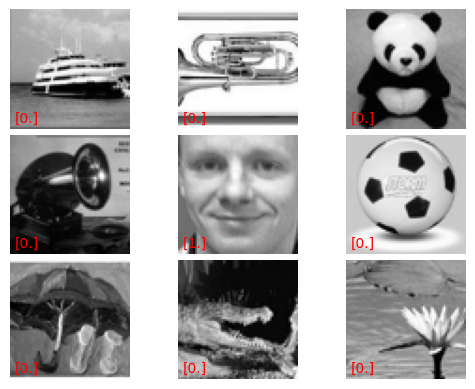

In [ ]:
# Random selection of 9 images
indexes = np.random.randint(0, len(X_test), size=9)

# Plot of the images
fig = plt.figure()
for i in range(len(indexes)):
  plot = fig.add_subplot(3, 3, i+1)
  plt.imshow(X_test[indexes[i]], cmap = "gray")
  y_pred = pipeline.predict(X_test[indexes[i], :])
  plot.text(2, 60, f"{y_pred}", color = 'red', fontsize=10)
  plt.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

The model seems to be good, there is no need here to improve it with gridsearch for example as the metrics are all equal to 100%.

## Model test on real picture

In order to try the face detection model on real picture, an image in downloaded from internet.

In [ ]:
def download(URL):
  # Download the image
  response = requests.get(URL)
  image_array = np.asarray(bytearray(response.content), dtype=np.uint8)

  # Decodify the image in a np array
  img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  return img

In [ ]:
URL = 'https://www.thetvaddict.com/wp-content/uploads/2014/09/Friends-Cast-Reunion.jpg'
img = download(URL)

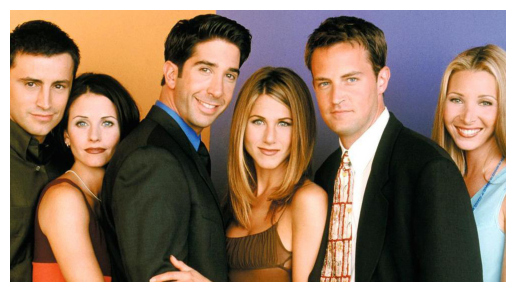

In [ ]:
# Visualize the image
plt.imshow(img)
plt.axis('off')
plt.show()

It has to be modified before using the pipeline. As the model has been trained on format images (64*64), in gray scale after normalization, it is essential to perform the same steps on this picture.

In [ ]:
# The picture is preprocessed
img_prep = preprocess_image(img)

# To carry on, we check we have a (64*64) image
print(f"Shape image: {img_prep.shape}")

Shape image: (64, 64)


In [ ]:
# The class is predicted by the pipeline
y_pred = pipeline.predict(img_prep)

# Print of the predicted class
if y_pred == 0:
  print(f" The predicted class for this picture is: {y_pred}, meaning absence of human face(s)")
if y_pred == 1:
    print(f" The predicted class for this picture is: {y_pred}, meaining presence of human face(s)")

 The predicted class for this picture is: [0.], meaning absence of human face(s)


That is surprising, the model doesn't detect the human faces in the pictures. </br>
From a computer point of view, the model has been trained to recognize only faces, without background, and without considering the rest of the body. As a consequence, it sees our picture as very different from the positive examples used to train it. </br>
We need to find a way to help him to detect littler faces on a whole picture. </br>



# Step 5: Sliding window & pyramid image techniques

To solve the issue previously mentioned, the sliding window technique could be used, combined with image pyramid as presented by Adrian Rosebrock in his already cited works:
- image pyramid creates different sizes of an image --> in our case it allow to detect human faces of different sizes in a picture ;
- sliding window inspects the whole picture to detect human faces wherever they can be located.

From a practical point of view, for each size of image pyramid and each position of the sliding window, HOG features will be calculated and the created model will classify the image it receives as containing human face or not.

## Image Pyramid Function

In [ ]:
def pyramid(image, scale=1.5, minSize=(64, 64)):
    # Return the original image
    yield image

    # Creation of a local copy for the pyramid
    current_image = image.copy()

    # Proceed with the pyramid process
    while True:
        # Calculate the new width and rescale the copy
        w = int(current_image.shape[1] / scale)
        current_image = imutils.resize(current_image, width=w)

        # If new scale too little, stop
        if current_image.shape[0] < minSize[1] or current_image.shape[1] < minSize[0]:
            break

        # Return the new reduced image
        yield current_image

We check the good functionning of this pyramid function, first printing the number of levels of it, then showing the different images obtained.

In [ ]:
pyramid_images = list(pyramid(img))
print(f"Number of levels in the pyramid: {len(pyramid_images)}")

Number of levels in the pyramid: 6


In [ ]:
def show_pyramid(image, scale=1.5, minSize=(64, 64)):
    fig, axes = plt.subplots(1, len(pyramid_images), figsize=(15, 5))

    i = 0
    for level in pyramid(image, scale=scale, minSize=minSize):
        if i >= len(pyramid_images):
            break

        axes[i].imshow(level, cmap='gray')
        axes[i].set_title(f"Level {i}")
        axes[i].axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

This function is applied to the image.

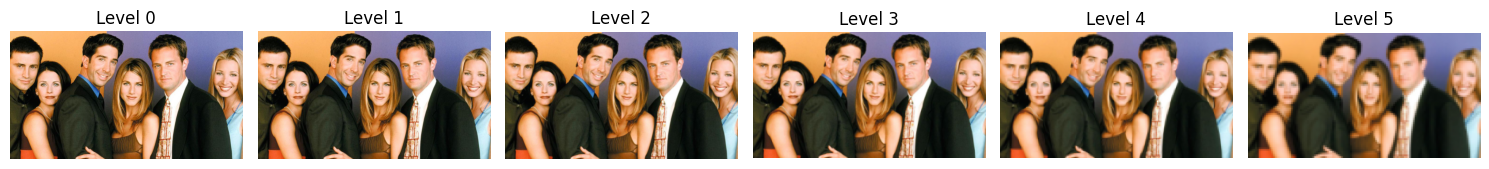

In [ ]:
show_pyramid(img)

From level 0 to 5, the image appears more pixeled, in realty the image is getting smaller, as a result there are less pixels. </br>
So far, it appears that image pyramid function works well. </br>


## Sliding Window Function

To carry on, it is needed to create a sliding window function to use on the pyramid images. </br>
As our model is trained for (64, 64) images, the sliding window size is fixed to (64, 64).

In [ ]:
def sliding_window(image, stepSize, windowSize = (64, 64)):

  	# slide the window across the image
    for y in range(0, image.shape[0] - windowSize[1] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[0] + 1, stepSize):
          	# return the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

We check the good functionning of this sliding window function drawing the windows on the picture. </br>
The test is done with parameters such as the sliding windows representation is clear: step_size of 32 pixels and window size of (128*128) (much smaller values are considered for the application to object detection).

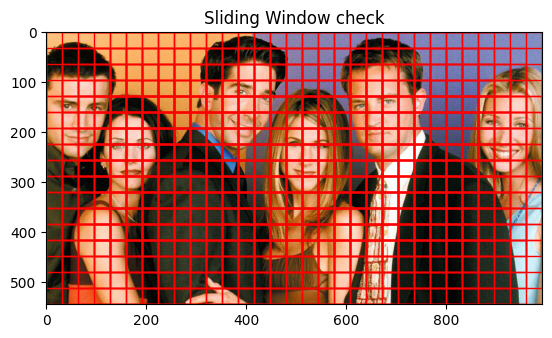

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

step_size = 32
window_size = (128, 128)

for (x, y, window) in sliding_window(img, stepSize=step_size, windowSize=window_size):
    rect = patches.Rectangle((x, y), window_size[0], window_size[1], edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.title("Sliding Window check")
plt.show()

The function seems to work well. </br>
Next step is to use both pyramid function and sliding window, together with pipeline application.

# Step 6: Model application to new image

## Main function to detect faces

Inside the function to detect faces, it is needed to use a function to preprocess (convert in gray scale and normalize the pixels) the sliding windows before applying the pipeline.

In [ ]:
def preprocess_image_pipeline(image_array):
    # Convert in PIL object
    pil_img = Image.fromarray(image_array)

    # Convert in gray scale
    pil_img = pil_img.convert('L')

    # Save as np array and normalization of pixel values
    gray_array = np.array(pil_img).astype(np.float32) / 255

    return gray_array

Then the main function is created, including previously defined pipeline. </br>
It takes as input an RGB image, and return the bounding boxes (list of tuples) where a face has been detected.


In [ ]:
def detect_objects(image, pipeline, scale=1.5, step_size=4, min_size=(64, 64), threshold=0.5):

    # Initialization of list of boxes containing human face
    boxes = []

    # The sliding window size must be equal to (64, 64) for the pipeline
    window_size = (64, 64)

    # For cycle to each pyramid image
    for resized in pyramid(image, scale=scale, minSize=min_size):

        scale_ratio = image.shape[1] / float(resized.shape[1])

        # For cycle to consider each sliding window generated on pyramid image
        for (x, y, window) in sliding_window(resized, stepSize=step_size, windowSize=window_size):

            # Avoid error on edges
            if window.shape[0] != 64 or window.shape[1] != 64:
                continue

            # Preprocess the window to make it OK for pipeline application
            processed = preprocess_image_pipeline(window)

            # The pipeline is applied in 2 steps:
            try:
                # HOG features extraction and their standardization
                features = pipeline[:-1].transform([processed])
                # Score calculation. It gives the possibility to change
                # the threshold from 0.5 and control false positives/negatives
                score = pipeline[-1].decision_function(features)[0]

            #In case of error, a message is raised (useful in debugging phase)
            except Exception as e:
                print(f"Error in the window ({x},{y}): {e}")
                continue

            # For positive classification case (depending on threshold value),
            # the bounding box is appended to the list
            if score > threshold:
                x_orig = int(x * scale_ratio)
                y_orig = int(y * scale_ratio)
                w_orig = int(window_size[0] * scale_ratio)
                h_orig = int(window_size[1] * scale_ratio)
                boxes.append((x_orig, y_orig, w_orig, h_orig, score))

    return boxes

Ss threshold value, a number of 0.4 is chosen. Indeed, for 0.5 some tilted faces were not detected, so a lower value is used to avoid false negative.

In [ ]:
thresh = 0.4

In [ ]:
# The function is applied to the picture
boxes = detect_objects(img, pipeline, threshold = thresh)

# As result, a list of tuples corresponding to the boxes with human faces is expected
print(boxes)

[(366, 102, 96, 96, np.float64(0.41400732539177904)), (366, 108, 96, 96, np.float64(0.43313157058580837)), (606, 120, 96, 96, np.float64(0.567882121736465)), (18, 126, 96, 96, np.float64(0.4400571448691007)), (24, 126, 96, 96, np.float64(0.714385274244514)), (18, 132, 96, 96, np.float64(0.4729223195264339)), (24, 132, 96, 96, np.float64(0.6552543966865512)), (870, 156, 96, 96, np.float64(0.842291578994208)), (876, 156, 96, 96, np.float64(0.8974526537686894)), (864, 162, 96, 96, np.float64(0.5290547292775465)), (870, 162, 96, 96, np.float64(1.0428815662919753)), (876, 162, 96, 96, np.float64(1.1063142761451934)), (882, 162, 96, 96, np.float64(0.4883356629710592)), (870, 168, 96, 96, np.float64(0.6975619755320639)), (876, 168, 96, 96, np.float64(0.7683651642169451)), (114, 198, 96, 96, np.float64(0.5538312474893812)), (120, 198, 96, 96, np.float64(0.9022323209118989)), (126, 198, 96, 96, np.float64(1.1069888674447086)), (468, 198, 96, 96, np.float64(0.8770035156590206)), (474, 198, 96, 9

It is interesting to show these boxes on the original image. To do it, a function draw_boxes is created and then used to draw the found boxes.

In [ ]:
def draw_boxes(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')

    for (x, y, w, h, score) in boxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

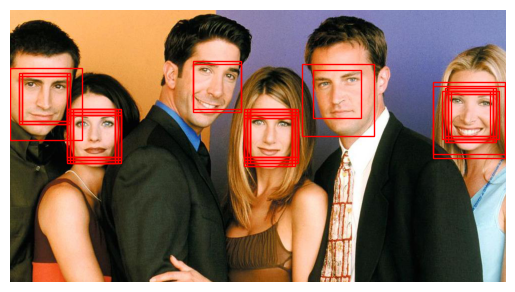

In [ ]:
# Show the boxes on the original image
draw_boxes(img, boxes)

Faces have been well detected, but for each one, there is an overlap of several boxes containing the same face. To have an only one box for each face, it is necessary to use Non-Maximum Suppression method.

## Non-Maximum Suppression

In [ ]:
def apply_nms(boxes, score_threshold=thresh, nms_threshold=0.3):

    # Check if there are boxes in the image, if not return an empty list
    if not boxes:
        return []

    # Separate for each box the coordinates and the score
    rects = [ [x, y, w, h] for (x, y, w, h, s) in boxes ]
    scores = [ float(s) for (x, y, w, h, s) in boxes ]

    # Application of NMS ; return the index of boxes to be kept
    indices = cv2.dnn.NMSBoxes(rects, scores, score_threshold, nms_threshold)

    # Creation of the list of boxes to be kept
    final_boxes = []

    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = rects[i]
            final_boxes.append((x, y, w, h, scores[i]))

    return final_boxes

We apply this function on the previously founded boxes.

In [ ]:
final_boxes = apply_nms(boxes, score_threshold=thresh)
print(f"Number of detected faces in the picture: {len(final_boxes)}")

Number of detected faces in the picture: 6


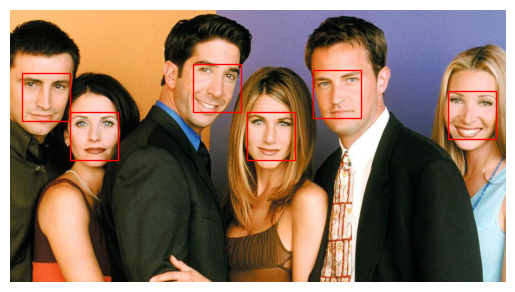

In [ ]:
draw_boxes(img, final_boxes)

The obtained result is satisfying. </br>
Nevertheless it is specified that the pipeline should take the picture as input and give the list of boxes as outputs. </br>
As a result, in the last part of this project we will try to build a pipeline including the last steps.

# Step 7: Final pipeline creation

It is not possible to use a classic sklearn pipeline to perform the whole face detection process from the input image to the output as coordinates of boxes with faces. </br>
In fact, it is conceived to proceed to transformations on np arrays to lead to classification or regression outputs.
</br>
Here the input is a RGB picture, and the output is an empty list, or a list of one or several tuples per image. </br>
As a result, we group all the different functions and steps in the face_detection_pipeline function.

In [ ]:
def face_detection_pipeline(image, pipeline, scale=1.5, step_size=4, min_size=(64, 64),
                            score_threshold=0.5, nms_threshold=0.3):

    # Step 1: Detect objects with previous pipeline + sliding window + pyramid
    raw_boxes = detect_objects(image, pipeline, scale=scale, step_size=step_size,
                               min_size=min_size, threshold=score_threshold)

    # Step 2: Apply NMS
    final_boxes = apply_nms(raw_boxes, score_threshold=score_threshold, nms_threshold=nms_threshold)

    return final_boxes

## Check on a no-face image

Let's import and visualize a new image.

In [ ]:
PIC_landscape = 'https://suvivaarla.com/wp-content/uploads/2022/03/th-37796.jpg'
img = download(PIC_landscape)

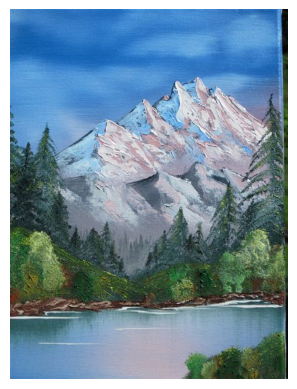

In [ ]:
# Visualize the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Application of the function to the image
thresh = 0.4
final_boxes = face_detection_pipeline(img, pipeline,
                                      score_threshold=thresh)

# Print of the boxes corresponding to human faces
print(final_boxes)

[]


The empty list corresponds to a non detection of human face here, which is true (landscape picture).

## Check on a one-face image

Let's import and visualize a new image.

In [ ]:
URL = 'https://static1.purepeople.com/articles/3/51/96/93/@/7632309-jean-reno-photocall-de-la-serie-a-pri-580x0-1.jpg'
img = download(URL)

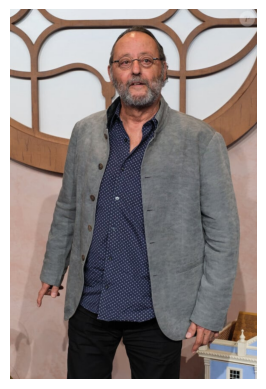

In [ ]:
# Visualize the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Application of the function to the image
thresh = 0.4
final_boxes = face_detection_pipeline(img, pipeline,
                                      score_threshold=thresh)

# Print of the boxes corresponding to human faces
print(final_boxes)

[(246, 96, 96, 96, 0.8690130373461282)]


Bounding boxes visualization

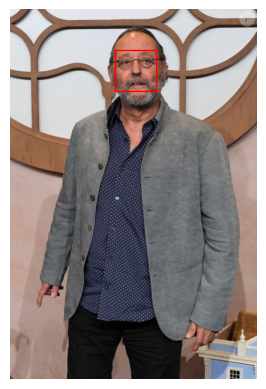

In [ ]:
draw_boxes(img, final_boxes)

As expected, Jean Reno face is well individualized in this picture.

## Check on a multiple faces image

Let's import and visualize a new image.

In [ ]:
URL = 'https://static1.moviewebimages.com/wordpress/wp-content/uploads/2022/08/wednesday-addams-family.jpg'
img = download(URL)

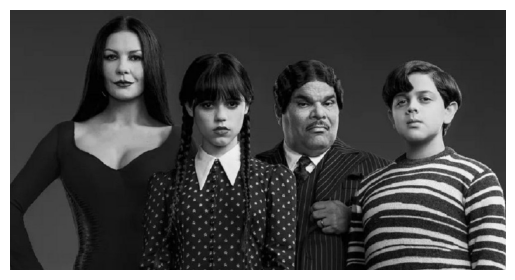

In [ ]:
# Visualize the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Application of the function to the image
thresh = 0.5
final_boxes = face_detection_pipeline(img, pipeline,
                                      score_threshold=thresh)

# Print of the boxes corresponding to human faces
print(final_boxes)

[(228, 96, 96, 96, 1.1685588208250022), (666, 189, 144, 144, 1.007682730833476), (930, 192, 96, 96, 0.6156098022951878), (462, 210, 96, 96, 0.6087541889466248)]


Bounding faces visualization

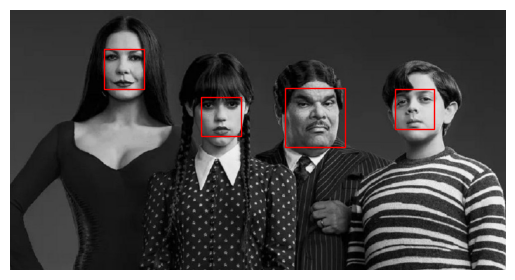

In [ ]:
draw_boxes(img, final_boxes)

The 4 faces of Adams family in the picture have been individualized.

# Conclusion

In this project, a face detection algorithm has been developped using limited calculation capacity. A preliminary bibliographic research has been done revealing that considering the project requirements, the use of HOG features together with SVC model could be a good starting point to classify images containing human faces vs images without. </br>
In a second time, considering a new picture to be tested through face detection, some techniques have been used like sliding window combined with image pyramid to individualize human faces present in it. Finally to avoid boxes overlapping for the same face, Non-Maximum Suppression method has been used. </br>
The final pipeline tested on different kind of cases (nobody on it, one person or several people) shows good results.